## Deep face recognition with Keras

In [0]:
from google.colab import drive

In [2]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
project_path = "/content/drive/My Drive/GLAIML/Face Recognition/"

In [4]:
%cd "/content/drive/My Drive/GLAIML/Face Recognition"

/content/drive/My Drive/GLAIML/Face Recognition


In [5]:
ls "/content/drive/My Drive/GLAIML/Face Recognition"

align.py                         model.png
data.py                          model.py
dataset/                         models/
_DS_Store                        nn4.small2.v1.h5
face_generator.py                predictor.py
face_generator.pyc               __pycache__/
_gitattributes                   requirements.txt
_gitignore                       ssd_box_encode_decode_utils.py
images/                          ssd_box_encode_decode_utils.pyc
images.zip                       ssd_mobilenet_face_epoch_25_loss0.0916.h5
keras_layer_AnchorBoxes.py       utils.py
keras_layer_AnchorBoxes.pyc      wider_extract.py
keras_layer_L2Normalization.py   WIDER_train/
keras_layer_L2Normalization.pyc  wider_train_small.npy
keras_ssd_loss.py                wider_train_v1.npy
keras_ssd_loss.pyc               WIDER_train.zip
__MACOSX/                        WIDER_val/
mn_model.py                      wider_val_small.npy
mn_model.pyc                     wider_val_v1.npy
mobilenet_1_0_224_tf.h5          WIDE

### First, lets install the required libraries. Upload the `requirements.txt` file given and run the below commands.

In [6]:
!pip install -r requirements.txt --user

  Using cached https://files.pythonhosted.org/packages/5f/b8/3dafc45f20a817ab9f042302646bcbe6f7e26e8a760871a85637e53a35ec/absl-py-0.1.10.tar.gz
  Using cached https://files.pythonhosted.org/packages/87/a9/7985e6a53402f294c8f0e8eff3151a83f1fb901fa92909bb3ff29b4d22af/appnope-0.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/33/70/86c5fec937ea4964184d4d6c4f0b9551564f821e1c3575907639036d9b90/bleach-1.5.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e1/5a/53db15bf367d2028bdc6700dbdf1bdfab46b9f208b7516952817c0808118/decorator-4.2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/cc/8b/4eefa9b47f1910b3d2081da67726b066e379b04ca897acfe9f92bac56147/entrypoints-0.2.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/24/9e/d68bd01058e748bd5e7c3c6368d1703b4cd882b669e5d993a0237c75af5a/h5py-2.7.1-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a

In [7]:
!pip install request

### Installing Dlib

In [8]:
!apt install python python-pip build-essential cmake pkg-config libx11-dev libatlas-base-dev libgtk-3-dev libboost-python-dev -y

!pip install dlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
pkg-config is already the newest version (0.29.1-0ubuntu2).
python is already the newest version (2.7.15~rc1-1).
libatlas-base-dev is already the newest version (3.10.3-5).
libboost-python-dev is already the newest version (1.65.1.0ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
libgtk-3-dev is already the newest version (3.22.30-1ubuntu4).
libx11-dev is already the newest version (2:1.6.4-3ubuntu0.2).
python-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


### Download Dlib's face landmarks data file for running face alignment.

This will helps us in aligning faces before we learn the features for each face. **`Run the below code.`** It will create a directory with name **`models` **and save **`landmarks.dat`** file in that folder.

In [0]:
import bz2
import os

from urllib import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)


### Training the network

The CNN model is taken from the Keras-OpenFace project. The architecture details aren't too important here, it's only useful to know that there is a fully connected layer with 128 hidden units followed by an L2 normalization layer on top of the convolutional base. These two top layers are referred to as the embedding layer from which the 128-dimensional embedding vectors can be obtained. The complete model is defined in `model.py` and a graphical overview is given in `model.png`. A Keras version of the `nn4.small2` model can be created with `create_model()`.


**Run the below code to initialize the model**

In [10]:
from model import create_model

nn4_small2 = create_model()

Using TensorFlow backend.
W0907 13:32:13.310072 140679546697600 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0907 13:32:13.356661 140679546697600 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0907 13:32:13.383317 140679546697600 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0907 13:32:13.429475 140679546697600 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0907 

#### Idea of Training the model with Triplet loss function 

Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a triplet loss L that is minimized when the distance between an anchor image xai and a positive image xpi (same identity) in embedding space is smaller than the distance between that anchor image and a negative image xni (different identity) by at least a margin α.

In [0]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [12]:
from data import triplet_generator

# triplet_generator() creates a generator that continuously returns 
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# and n_batch are batches of anchor, positive and negative RGB images 
# each having a shape of (batch_size, 96, 96, 3).
generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

# Please note that the current implementation of the generator only generates 
# random image data. The main goal of this code snippet is to demonstrate 
# the general setup for model training. In the following, we will anyway 
# use a pre-trained model so we don't need a generator here that operates 
# on real training data.

W0907 13:32:24.726501 140679546697600 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0907 13:32:24.858093 140679546697600 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
100/100 [==============================] - 91s 914ms/step - loss: 0.8225
Epoch 2/10
100/100 [==============================] - 78s 779ms/step - loss: 0.8016
Epoch 3/10
100/100 [==============================] - 78s 782ms/step - loss: 0.7996
Epoch 4/10
100/100 [==============================] - 79s 787ms/step - loss: 0.8000
Epoch 5/10
100/100 [==============================] - 78s 782ms/step - loss: 0.8000
Epoch 6/10
100/100 [==============================] - 79s 790ms/step - loss: 0.8018
Epoch 7/10
100/100 [==============================] - 79s 786ms/step - loss: 0.8002
Epoch 8/10
100/100 [==============================] - 79s 790ms/step - loss: 0.7991
Epoch 9/10
100/100 [==============================] - 78s 782ms/step - loss: 0.7957
Epoch 10/10
100/100 [==============================] - 79s 791ms/step - loss: 0.8001


For this project, we are considering a pre-trained model given in file path **`nn4.small2.v1.h5`**.

Write code: Using **load_weights()** function load the given pre-trained weight file.

In [0]:

nn4_small2_pretrained = create_model()

nn4_small2_pretrained.load_weights('nn4.small2.v1.h5', by_name=True)

### Dataset

To demonstrate face recognition on a custom dataset, a small dataset is used. It consists of around 15-25 face images of 10 different persons. The metadata for each image (file and identity name) are loaded into memory for later processing.


Upload Images zip file given to drive and download and extract it using the below code. And we will pass the folder `images` to `load_metadata` function to save all the images filenames and person numbers.

#### Import drive module from google.colab

In [0]:
#already done
from google.colab import drive

#### Give a path to mount the files in your drive

In [0]:
drive.mount("/content/drive/")

#### Using the above given mounted path, give the images.zip path dependent on where you placed the file in your drive.

In [0]:
## For example
images_path =  "/content/drive/My Drive/GLAIML/Face Recognition/"

In [15]:
!ls

align.py			 model.py
data.py				 model.pyc
data.pyc			 models
dataset				 nn4.small2.v1.h5
_DS_Store			 predictor.py
face_generator.py		 __pycache__
face_generator.pyc		 requirements.txt
_gitattributes			 ssd_box_encode_decode_utils.py
_gitignore			 ssd_box_encode_decode_utils.pyc
images				 ssd_mobilenet_face_epoch_25_loss0.0916.h5
images.zip			 utils.py
keras_layer_AnchorBoxes.py	 utils.pyc
keras_layer_AnchorBoxes.pyc	 wider_extract.py
keras_layer_L2Normalization.py	 WIDER_train
keras_layer_L2Normalization.pyc  wider_train_small.npy
keras_ssd_loss.py		 wider_train_v1.npy
keras_ssd_loss.pyc		 WIDER_train.zip
__MACOSX			 WIDER_val
mn_model.py			 wider_val_small.npy
mn_model.pyc			 wider_val_v1.npy
mobilenet_1_0_224_tf.h5		 WIDER_val.zip
model.png


#### Using ZipFile module to extract the images zip file

In [0]:
from zipfile import ZipFile

In [0]:
with ZipFile('/content/drive/My Drive/GLAIML/Face Recognition/'+'/images.zip', 'r') as zip:
  zip.extractall()

#### Run the below function to load the images from the extracted images folder from the above step and map each image with person id 


In [0]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

### Face alignment
The nn4.small2.v1 model was trained with aligned face images, therefore, the face images from the custom dataset must be aligned too. Here, we use Dlib for face detection and OpenCV for image transformation and cropping to produce aligned 96x96 RGB face images. We are using the AlignDlib utility from the OpenFace project.

##### 1. Run the below code to import AlignDlib

For this you need align.py available in the environment.

In [0]:
# Copyright 2015-2016 Carnegie Mellon University
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Module for dlib-based alignment."""

import cv2
import dlib
import numpy as np

TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)


class AlignDlib:
    """
    Use `dlib's landmark estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`_ to align faces.

    The alignment preprocess faces for input into a neural network.
    Faces are resized to the same size (such as 96x96) and transformed
    to make landmarks (such as the eyes and nose) appear at the same
    location on every image.

    Normalized landmarks:

    .. image:: ../images/dlib-landmark-mean.png
    """

    #: Landmark indices.
    INNER_EYES_AND_BOTTOM_LIP = [39, 42, 57]
    OUTER_EYES_AND_NOSE = [36, 45, 33]

    def __init__(self, facePredictor):
        """
        Instantiate an 'AlignDlib' object.

        :param facePredictor: The path to dlib's
        :type facePredictor: str
        """
        assert facePredictor is not None

        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(facePredictor)

    def getAllFaceBoundingBoxes(self, rgbImg):
        """
        Find all face bounding boxes in an image.

        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :return: All face bounding boxes in an image.
        :rtype: dlib.rectangles
        """
        assert rgbImg is not None

        try:
            return self.detector(rgbImg, 1)
        except Exception as e:
            print("Warning: {}".format(e))
            # In rare cases, exceptions are thrown.
            return []

    def getLargestFaceBoundingBox(self, rgbImg, skipMulti=False):
        """
        Find the largest face bounding box in an image.

        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param skipMulti: Skip image if more than one face detected.
        :type skipMulti: bool
        :return: The largest face bounding box in an image, or None.
        :rtype: dlib.rectangle
        """
        assert rgbImg is not None

        faces = self.getAllFaceBoundingBoxes(rgbImg)
        if (not skipMulti and len(faces) > 0) or len(faces) == 1:
            return max(faces, key=lambda rect: rect.width() * rect.height())
        else:
            return None

    def findLandmarks(self, rgbImg, bb):
        """
        Find the landmarks of a face.

        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param bb: Bounding box around the face to find landmarks for.
        :type bb: dlib.rectangle
        :return: Detected landmark locations.
        :rtype: list of (x,y) tuples
        """
        assert rgbImg is not None
        assert bb is not None

        points = self.predictor(rgbImg, bb)
        return list(map(lambda p: (p.x, p.y), points.parts()))

    def align(self, imgDim, rgbImg, bb=None,
              landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP,
              skipMulti=False):
        r"""align(imgDim, rgbImg, bb=None, landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP)

        Transform and align a face in an image.

        :param imgDim: The edge length in pixels of the square the image is resized to.
        :type imgDim: int
        :param rgbImg: RGB image to process. Shape: (height, width, 3)
        :type rgbImg: numpy.ndarray
        :param bb: Bounding box around the face to align. \
                   Defaults to the largest face.
        :type bb: dlib.rectangle
        :param landmarks: Detected landmark locations. \
                          Landmarks found on `bb` if not provided.
        :type landmarks: list of (x,y) tuples
        :param landmarkIndices: The indices to transform to.
        :type landmarkIndices: list of ints
        :param skipMulti: Skip image if more than one face detected.
        :type skipMulti: bool
        :return: The aligned RGB image. Shape: (imgDim, imgDim, 3)
        :rtype: numpy.ndarray
        """
        assert imgDim is not None
        assert rgbImg is not None
        assert landmarkIndices is not None

        if bb is None:
            bb = self.getLargestFaceBoundingBox(rgbImg, skipMulti)
            if bb is None:
                return

        if landmarks is None:
            landmarks = self.findLandmarks(rgbImg, bb)

        npLandmarks = np.float32(landmarks)
        npLandmarkIndices = np.array(landmarkIndices)

        H = cv2.getAffineTransform(npLandmarks[npLandmarkIndices],
                                   imgDim * MINMAX_TEMPLATE[npLandmarkIndices])
        thumbnail = cv2.warpAffine(rgbImg, H, (imgDim, imgDim))

        return thumbnail

In [0]:
from mn_model import mn_model

In [22]:
from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from keras.models import load_model
from keras import backend as K

img_height =512
img_width = 512

img_channels = 3

n_classes =2 
class_names = ["background","face"]

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True

model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)

#model.summary()
model_path = './'
model_name = 'ssd_mobilenet_face_epoch_25_loss0.0916.h5'

model.load_weights(model_path + model_name,  by_name= True)

face_generator.py:39: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "</usr/local/lib/python2.7/dist-packages/decorator.pyc:decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 87

====> Model Specific data
====> Height, Width, Channels : 512 512 3


mn_model.py:287: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), kernel_initializer="glorot_uniform", name="detection_conv6_1", activation=None, padding="same", strides=(1, 1), kernel_regularizer=None, use_bias=True)`
  tmp_layer = Convolution2D(nb_filter, nb_row, nb_col, subsample=subsample, activation=None, border_mode=border_mode, name = layer_name, bias=bias, init=init_, W_regularizer= W_regularizer)(tmp_layer)
mn_model.py:287: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), kernel_initializer="glorot_uniform", name="detection_conv7_1", activation=None, padding="same", strides=(1, 1), kernel_regularizer=None, use_bias=True)`
  tmp_layer = Convolution2D(nb_filter, nb_row, nb_col, subsample=subsample, activation=None, border_mode=border_mode, name = layer_name, bias=bias, init=init_, W_regularizer= W_regularizer)(tmp_layer)
mn_model.py:287: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), k

Use the landmarks data file downloaded in the first steps for face alignment. file path **`models/landmarks.dat`**

In [0]:
# Initialize the OpenFace face alignment utility
alignment = AlignDlib('/content/drive/My Drive/GLAIML/Face Recognition/models/landmarks.dat')

##### 2. Run the beloiw code to  load an image from the metadata created in the step before Face Alignment

You can access each image path from `metadata[i].image_path()` where, i is the image number. i can take values from 1 to no.of images in the dataset given.

In [0]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [0]:
# Load an image
# for example, loading the image with index 1
one_image = load_image(metadata[0].image_path())

(592, 896, 3)


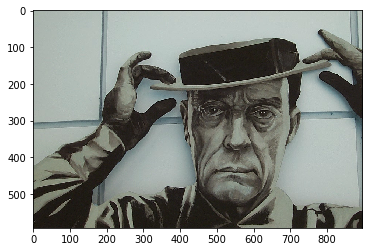

In [27]:
print(one_image.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()

# Show original image
# OpenCV loads images with color channels
# in BGR order. So we need to reverse them everytime we use matplotlib to show the image.
# Otherwise you see the image in false colour
plt.imshow(one_image[...,::-1])

#### Write code to load 2nd and 3rd images in the metadata using load_image()

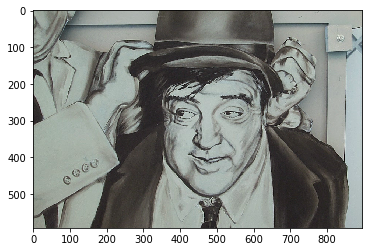

In [28]:
second_image = load_image(metadata[2].image_path())
plt.figure()
plt.imshow(second_image[...,::-1])

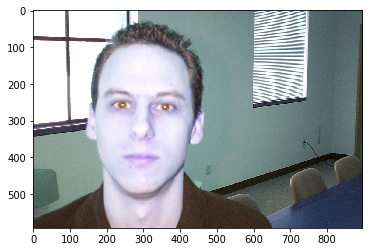

In [29]:
third_image = load_image(metadata[3].image_path())
plt.figure()
plt.imshow(third_image[...,::-1])

##### 3. Run the below code to align the above loaded image.

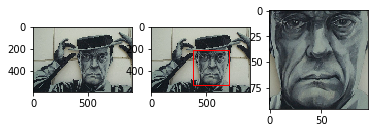

In [30]:
# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(one_image)

# Transform image using specified face landmark indices and crop image to 96x96
one_image_aligned = alignment.align(96, one_image, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Show original image
plt.subplot(131)
plt.imshow(one_image)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(one_image)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(one_image_aligned);

In [0]:
from keras.models import Model

In [0]:
def face_bb(test_img, show_img=False):
    img_height =512
    img_width = 512
    img_channels = 3
    _CONF = 0.60
    _IOU = 0.15
    coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
    normalize_coords = True
    org_height = test_img.shape[0]
    org_width = test_img.shape[1]
    
    resized_img = cv2.resize(test_img, (512, 512))
    test_img_input = np.expand_dims(resized_img,axis=0)
    y_pred = model.predict(test_img_input)
    y_pred_decoded = decode_y2(y_pred,
                                 confidence_thresh=_CONF,
                                iou_threshold=_IOU,
                                top_k='all',
                                input_coords=coords,
                                normalize_coords=normalize_coords,
                                img_height=img_height,
                                img_width=img_width)
    result = y_pred_decoded[0][0]
    det_label = result[0]
    det_conf = result[1]
    det_xmin = result[2]
    det_xmax = result[3]
    det_ymin = result[4]
    det_ymax = result[5]
    
    #Converting to integers as the indexes to images are only integers
    bb = [int(det_xmin),int(det_xmax),int(det_ymin),int(det_ymax)]
    
    if(show_img == True):      
      # Create figure and axes
      fig,ax = plt.subplots(1)

      # Display the image
      ax.imshow(resized_img[...,::-1], extent=[0, img_width, 0, img_height])
      
      lower_left = (det_xmin, det_ymin)
      width = det_xmax - det_xmin
      height = det_ymax - det_ymin
      
      print('-' * 40)
      print("RESIZED IMAGE WITH BOUNDING BOX FOR FACE\n" + '-' * 40)
      print(" lower left={}\n width={}\n height={}".format(lower_left, width, height))
      print(" xmin={}, ymin={}, xmax={}, ymax={}".format(bb[0], bb[2], bb[1], bb[3]))

      # Create a Rectangle patch
      rect = patches.Rectangle(lower_left, 
                               width, 
                               height, 
                               linewidth=1, 
                               edgecolor='r', 
                               facecolor='none')

      # Add the patch to the Axes
      ax.add_patch(rect)

      plt.show()
    
    return resized_img, bb

#### Write a function image_align() which take image path as input and returns the aligned image in output.



In [0]:
def image_align(img_path, show_img=False):
  crop_img_width = 96
  crop_img_height = 96
  
  resized_img, bb = face_bb(load_image(img_path), show_img=show_img)

  crop_img = resized_img[bb[2]:bb[3], bb[0]:bb[1]]
  crop_img = cv2.resize(crop_img, (crop_img_width, crop_img_height))

  if(show_img == True):      
    # Create figure and axes
    fig,ax = plt.subplots(1)

    print('-' * 13)
    print("CROPPED IMAGE\n" + '-' * 13)
    print(" width={}\n height={}".format(crop_img_width, crop_img_height))
    
    # Display the image
    ax.imshow(crop_img[...,::-1], extent=[0, crop_img_width, 0, crop_img_height])

    plt.show()

  return crop_img
  

### Generate embeddings for each image in the dataset

Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

#### Get embedding vector for first image in the metadata using the pre-trained model

In [0]:
# Align the image
img_aligned = image_align(metadata[0].image_path())

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img_aligned / 255.).astype(np.float32)

# obtain embedding vector for an image
embedding_vector = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

#### Write code to iterate through metadata and create embeddings for each image using nn4_small2_pretrained.predict() and store in a list with name `embeddings`

If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 128-zeroes as the final embedding from the model is of length 128.

In [0]:
def get_face(img_path, show_img=False):
  crop_img_width = 96
  crop_img_height = 96
  
  resized_img, bb = face_bb(load_image(img_path), show_img=show_img)

  crop_img = resized_img[bb[2]:bb[3], bb[0]:bb[1]]
  crop_img = cv2.resize(crop_img, (crop_img_width, crop_img_height))

  if(show_img == True):      
    # Create figure and axes
    fig,ax = plt.subplots(1)

    print('-' * 13)
    print("CROPPED IMAGE\n" + '-' * 13)
    print(" width={}\n height={}".format(crop_img_width, crop_img_height))
    
    # Display the image
    ax.imshow(crop_img[...,::-1], extent=[0, crop_img_width, 0, crop_img_height])

    plt.show()

  return crop_img

In [36]:
# Align the image
cropped_img = get_face(metadata[0].image_path())

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (cropped_img / 255.).astype(np.float32)

# obtain embedding vector for an image
embedding_vector = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))

print("PREDICTED EMBEDDING ARRAY SHAPE:")
print(embedding_vector.shape)

print("")
print("INNER EMBEDDING VECTOR SHAPE:")
print(embedding_vector[0].shape)

PREDICTED EMBEDDING ARRAY SHAPE:
(1, 128)

INNER EMBEDDING VECTOR SHAPE:
(128,)


In [0]:
def get_embedding_vector(metadata_item):
  cropped_img = get_face(metadata_item.image_path())

  print("{}...".format(metadata_item.file)),   
  
  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
  img = (cropped_img / 255.).astype(np.float32)

  # obtain embedding vector for an image
  embedding_vector = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))

  print("shape={}...DONE!".format(embedding_vector[0].shape))  
  
  return embedding_vector[0]

In [38]:
embeddings = []

for md in metadata:
  embeddings.append(get_embedding_vector(md))
  
print(len(embeddings))

image_0400.jpg... shape=(128,)...DONE!
image_0402.jpg... shape=(128,)...DONE!
image_0403.jpg... shape=(128,)...DONE!
image_0404.jpg... shape=(128,)...DONE!
image_0405.jpg... shape=(128,)...DONE!
image_0408.jpg... shape=(128,)...DONE!
image_0407.jpg... shape=(128,)...DONE!
image_0406.jpg... shape=(128,)...DONE!
image_0419.jpg... shape=(128,)...DONE!
image_0423.jpg... shape=(128,)...DONE!
image_0418.jpg... shape=(128,)...DONE!
image_0422.jpg... shape=(128,)...DONE!
image_0424.jpg... shape=(128,)...DONE!
image_0428.jpg... shape=(128,)...DONE!
image_0416.jpg... shape=(128,)...DONE!
image_0413.jpg... shape=(128,)...DONE!
image_0412.jpg... shape=(128,)...DONE!
image_0410.jpg... shape=(128,)...DONE!
image_0417.jpg... shape=(128,)...DONE!
image_0411.jpg... shape=(128,)...DONE!
image_0420.jpg... shape=(128,)...DONE!
image_0426.jpg... shape=(128,)...DONE!
image_0415.jpg... shape=(128,)...DONE!
image_0427.jpg... shape=(128,)...DONE!
image_0421.jpg... shape=(128,)...DONE!
image_0414.jpg... shape=(

#### Write code to get the distance between given 2 pairs of images.

Consider distance metric as "Squared L2 distance"

squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2



##### Plot images and get distance between the pairs given below.

1. 2,3 and 2,120

2. 30,31 and 30,100

3. 70,72 and 70,115

In [0]:
def get_dist_between_images(ref_img_idx, target_img_idx, show_img=False):
  l = ref_img_idx
  r = target_img_idx
  
  dist = np.square(embeddings[l] - embeddings[r]).sum()
  
  if(show_img == True):
    print("DISTANCE BETWEEN THESE 2 IMAGES = {}".format(dist))

    fig,ax = plt.subplots(1, 2)
    
    ax[0].imshow(load_image(metadata[l].image_path())[...,::-1])
    ax[1].imshow(load_image(metadata[r].image_path())[...,::-1])

    plt.show()
  
  return dist

In [0]:
def show_dist_between_pairs(ref_img_idx, target_img1_idx, target_img2_idx):
  ref = ref_img_idx
  one = target_img1_idx
  two = target_img2_idx
  
  print('-' * 45)
  pair1_dist = get_dist_between_images(ref, one, True)
  print('.' * 45)
  pair2_dist = get_dist_between_images(ref, two, True)

  print('_' * 45)
  print("DISTANCE BETWEEN THE 2 PAIRS = {}".format(abs(pair1_dist - pair2_dist)))
  print('-' * 45)

---------------------------------------------
DISTANCE BETWEEN THESE 2 IMAGES = 0.212253391743


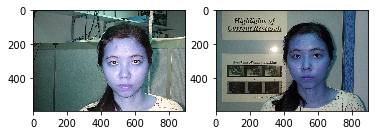

.............................................
DISTANCE BETWEEN THESE 2 IMAGES = 0.576712548733


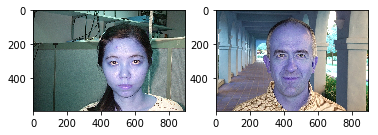

_____________________________________________
DISTANCE BETWEEN THE 2 PAIRS = 0.36445915699
---------------------------------------------


In [41]:
show_dist_between_pairs(10, 12, 131)

---------------------------------------------
DISTANCE BETWEEN THESE 2 IMAGES = 0.320544958115


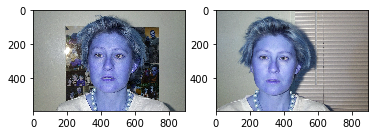

.............................................
DISTANCE BETWEEN THESE 2 IMAGES = 0.85185021162


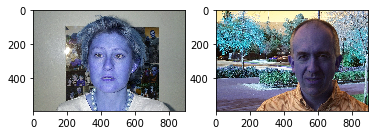

_____________________________________________
DISTANCE BETWEEN THE 2 PAIRS = 0.531305253506
---------------------------------------------


In [44]:
show_dist_between_pairs(60, 62, 150)

---------------------------------------------
DISTANCE BETWEEN THESE 2 IMAGES = 0.0740117356181


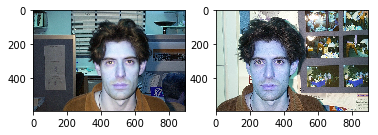

.............................................
DISTANCE BETWEEN THESE 2 IMAGES = 0.934879720211


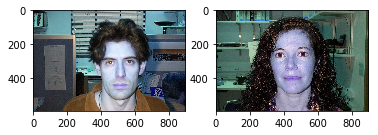

_____________________________________________
DISTANCE BETWEEN THE 2 PAIRS = 0.860867977142
---------------------------------------------


In [42]:
show_dist_between_pairs(30, 31, 100)

#### Now lets build a SVM classifier to predict person in the given image. 

Use LinearSVC in sklearn.svm

Run the below code to divide half of the images as training set and another half of the images as test set.

In [45]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

targets = np.array([(m.name) for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(1, metadata.shape[0], 2) # Take all odd indices as training set
test_idx = np.arange(0, metadata.shape[0], 2) # Take all even indices as test set

## checking the shapes of metaadata and test and train sets
print("TOTAL # OF IMAGES      : {}".format(metadata.shape))
print("# OF TRAINING IMAGES   : {}".format(train_idx.shape))
print("# OF TEST IMAGES       : {}".format(test_idx.shape))
print("-" * 45)


# one half as train examples of 10 identities
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]


y_train = y[train_idx]
y_test = y[test_idx]



print("TRAINING FEATURES SHAPE : {}".format(X_train.shape))
print("TRAINING LABELS SHAPE   : {}".format(y_train.shape))
print("-" * 45)
print("TEST FEATURES SHAPE : {}".format(X_test.shape))
print("TEST LABELS SHAPE   : {}".format(y_test.shape))

TOTAL # OF IMAGES      : (201,)
# OF TRAINING IMAGES   : (100,)
# OF TEST IMAGES       : (101,)
---------------------------------------------
TRAINING FEATURES SHAPE : (100, 128)
TRAINING LABELS SHAPE   : (100,)
---------------------------------------------
TEST FEATURES SHAPE : (101, 128)
TEST LABELS SHAPE   : (101,)


#### Build SVM and report the accuracy

SVM accuracy = 0.930693069307
_____________________________________________
PREDICTED PERSON (ID/FOLDER NAME) : [0]
ACTUAL PERSON (ID/FOLDER NAME)    : subject_0
_____________________________________________


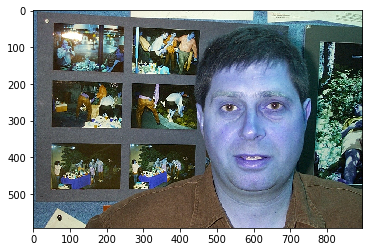

In [46]:
svc = LinearSVC()
svc.fit(X_train, y_train)
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print('SVM accuracy = {}'.format(acc_svc))
print('_' * 45)


i_test = 35
i_orig = test_idx[i_test]
    
print("PREDICTED PERSON (ID/FOLDER NAME) : {}".format(svc.predict(np.reshape(X_test[i_test], (1, 128)))))
print("ACTUAL PERSON (ID/FOLDER NAME)    : {}".format(metadata[i_orig].name))

print('_' * 45)
plt.imshow(load_image(metadata[i_orig].image_path())[...,::-1])
plt.show()

#### Test the classifier

Take 35th image from test set and plot the image, report to which person(folder name in dataset) the image belongs to.

PREDICTED PERSON (ID/FOLDER NAME) : [8]
ACTUAL PERSON (ID/FOLDER NAME)    : subject_7
_____________________________________________


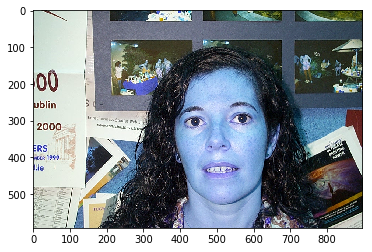

In [47]:
i_test = 45
i_orig = test_idx[i_test]
    
print("PREDICTED PERSON (ID/FOLDER NAME) : {}".format(svc.predict(np.reshape(X_test[i_test], (1, 128)))))
print("ACTUAL PERSON (ID/FOLDER NAME)    : {}".format(metadata[i_orig].name))

print('_' * 45)
plt.imshow(load_image(metadata[i_orig].image_path())[...,::-1])
plt.show()